In [1]:
#On importe les modules qui vont biens
import numpy as np
from  matplotlib import pyplot as plt
from scipy.signal import fftconvolve as fftcon

In [2]:
#On definit les parametres du programme
monfichier = "./toto.out"

zone_freq = [0,4000]
reso_spectre = 1

psv_mu_ir = 0.5
psv_mu_ram = 0.5
psv_fwhm_ir = 15
psv_fwhm_ram = 6

In [3]:
#On definit la fonction qui transforme le dirac en pseudovoigt
def psvoigt(x,x0,Int,mu,fwhm):
    return Int * ((2.0*mu/np.pi) * (fwhm/(4.0*(x-x0)**2+fwhm**2))   
                  + (1-mu)*(np.sqrt(4.0*np.log(2.0))/(np.sqrt(np.pi*fwhm)))      
                  * np.exp(-(4.0*np.log(2.0))/fwhm**2 * (x-x0)**2))

In [4]:
#On lit les information dans le fichier de sortie de crystal
f = open(monfichier,"r") 
content = f.readlines()

In [5]:
#On cherche les donnees IR
start_l=[]
end_l  =[]

for i,j in enumerate(content):
    if ' CONVERSION FACTORS FOR FREQUENCIES:' in j:
        start_l.append(i+8)

#Pour trouver la fin de la liste de freq j'ai du cherche une ligne vide precedee d'une ligne avec ) et I ou A        
    if (j == '\n' and '(  ' in content[i-1]  and ('I' or 'A') in content[i-1]) :
        end_l.append(i)
        
length_l = end_l[0] - start_l[0]


#On lit les donnes dans le fichier en suivant le formatage (colonnes de taille fixe)

Data = np.loadtxt(fname=monfichier,skiprows=start_l[0], max_rows=length_l, dtype=object, delimiter="none")

freq_IR = []
IntIR = []

for ligne in Data :
    freq_IR.append(ligne[24:35])
    IntIR.append(ligne[59:67])

IR = [freq_IR,IntIR]
IR = np.array(IR, dtype=np.float32)
IR = IR.T

In [6]:
#On cherche les donnees Raman si on en trouve pas on laisse le flag found_raman à 0
#ce qui permettra de skipper les calculs plus tard
start_l=[]
end_l  =[]
found_raman = 0

for i,j in enumerate(content):
    if 'POLYCRYSTALLINE ISOTROPIC INTENSITIES (ARBITRARY UNITS)' in j:
        found_raman = 1
        start_l.append(i+4)
    
    if 'SINGLE CRYSTAL DIRECTIONAL INTENSITIES (ARBITRARY UNITS)' in j:
        end_l.append(i-1)
        
if found_raman == 1 :
    length_l = end_l[0] - start_l[0]
    Data = np.loadtxt(fname=monfichier,skiprows=start_l[0], max_rows=length_l, dtype=object)
    freq_Ram = np.array(Data[:,2:3], dtype=np.float32)
    Intram = np.array(Data[:,5:8], dtype=np.float32)
    
    Raman = np.concatenate((freq_Ram,Intram), axis=1)

In [7]:
#On genere les x pour les spectres
x_spectre=np.linspace(zone_freq[0],zone_freq[1],int((zone_freq[1] - zone_freq[0])/reso_spectre))

In [8]:
#On dimensionne les fichiers de sortie
spectre_ir = np.array(np.zeros((len(x_spectre),4),dtype=np.float32))
if found_raman == 1 : spectre_raman = np.array(np.zeros((len(x_spectre),4),dtype=np.float32))

In [9]:
#On trace la pseudovoigt centrée sur la zone (on va la convoluer avec des diracs pour avoir la forme des pics)
#On le fait pour l'IR et pour le Raman
Int_psv_ir = np.zeros(len(x_spectre))
if found_raman == 1 : Int_psv_ram = np.zeros(len(x_spectre))

for i, freq in enumerate(x_spectre) :
    Int_psv_ir[i] = psvoigt(freq,(zone_freq[1] - zone_freq[0])/2,Int=1.,mu=psv_mu_ir,fwhm=psv_fwhm_ir)
    if found_raman == 1 : Int_psv_ram[i] = psvoigt(freq,(zone_freq[1] - zone_freq[0])/2,Int=1.,mu=psv_mu_ram,fwhm=psv_fwhm_ram)

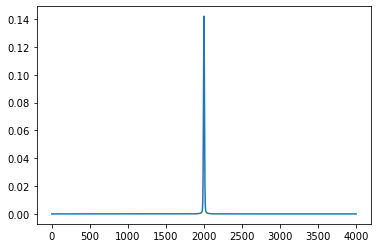

In [10]:
#Je trace le spectre pour verifier que tout va bien
Spectre_psv_ir = np.column_stack((x_spectre,Int_psv_ir))
if found_raman == 1 : Spectre_psv_ram = np.column_stack((x_spectre,Int_psv_ram))

plt.plot(Spectre_psv_ir[:,0],Spectre_psv_ir[:,1])
if found_raman == 1 : plt.plot(Spectre_psv_ram[:,0],Spectre_psv_ram[:,1])
plt.show()

In [11]:
#On cree le tableau qui contient les intensites des diracs
Int_dir_ir = np.zeros(len(x_spectre))
if found_raman == 1 : Int_dir_ram = np.zeros((len(x_spectre),3))

#On initialise les variables pour le remplissage du tableau
seuil = abs((x_spectre[1] - x_spectre[0])/2)
Ram_freq = 0
IR_freq = 0

In [12]:
#On remplit les tableaux : on fait defiler les frequences et on somme les intensites des modes IR ou Raman lorsque
#la difference entre le frequence en cours et le mode est inferieur a un seuil
#(pour arrondir le dirac a l'abscisse la plus proche du spectre)
#La boucle while sert a sommer les intensite des modes degeneres

if found_raman == 1 :
    for i, freq in enumerate(x_spectre) :
        while abs(freq - Raman[Ram_freq,0]) <= seuil :
            if Ram_freq <= (len(Raman) - 1) :
                Int_dir_ram[i,0:3] = Int_dir_ram[i,0:3] + Raman[Ram_freq,1:4]
                if Ram_freq < (len(Raman) - 1) :
                    Ram_freq += 1
                else : break
            else : break
    
        if IR[IR_freq,0] > 0 :
            while abs(freq - IR[IR_freq,0]) <= seuil :
                if IR_freq <= (len(IR) - 1) :
                    Int_dir_ir[i] = Int_dir_ir[i] + IR[IR_freq,1]
                    if IR_freq < (len(IR) - 1) :
                        IR_freq += 1
                    else : break
                else : break
        else : 
            IR_freq += 1

else :
    for i, freq in enumerate(x_spectre) :
        if IR[IR_freq,0] > 0 :
            while abs(freq - IR[IR_freq,0]) <= seuil :
                if IR_freq <= (len(IR) - 1) :
                    Int_dir_ir[i] = Int_dir_ir[i] + IR[IR_freq,1]
                    if IR_freq < (len(IR) - 1) :
                        IR_freq += 1
                    else : break
                else : break
        else : 
            IR_freq += 1

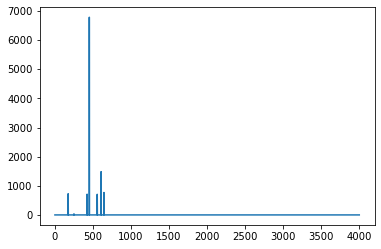

In [13]:
#Je trace le spectre IR pour verifier que tout va bien
Spectre_dir_ir = np.column_stack((x_spectre,Int_dir_ir))

plt.plot(Spectre_dir_ir[:,0],Spectre_dir_ir[:,1])
plt.show()

In [14]:
#Je trace le spectre raman pour verifier que tout va bien
if found_raman == 1 :
    Spectre_dir_ram = np.column_stack((x_spectre,Int_dir_ram))
    
    plt.plot(Spectre_dir_ram[:,0],Spectre_dir_ram[:,1:4])
    plt.show()

In [15]:
#Je convolue le spectre de dirac avec celui de pseudovoigt 
Int_conv_ir = np.zeros(len(x_spectre))
if found_raman == 1 : Int_conv_ram = np.zeros((len(x_spectre),3))

Int_conv_ir = fftcon(Int_psv_ir,Int_dir_ir,mode="same")

if found_raman == 1 :
    for i in range(3) :
        Int_conv_ram[:,i] = fftcon(Int_psv_ram,Int_dir_ram[:,i],mode="same")


Spectre_ir = np.column_stack((x_spectre,Int_conv_ir))
if found_raman == 1 : Spectre_ram = np.column_stack((x_spectre,Int_conv_ram))

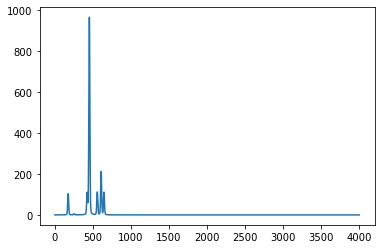

In [16]:
#Je trace le spectre IR pour verifier que tout va bien
plt.plot(Spectre_ir[:,0],Spectre_ir[:,1])
plt.show()

In [17]:
#Je trace le spectre pour verifier que tout va bien
if found_raman == 1 :
    plt.plot(Spectre_ram[:,0],Spectre_ram[:,1:4])
    plt.show()

In [18]:
#La ligne suivante est pour ecrire le fichier qui liste les intensites Raman
np.savetxt(fname='IR.txt',X = Spectre_ir)
if found_raman == 1 : np.savetxt(fname='Raman.txt',X = Spectre_ram)
f.close()